In [1]:
import os
import re
import gensim
import pandas as pd

from pprint import pprint
from gensim import corpora
from nltk.stem.wordnet import WordNetLemmatizer
from vuepoint.vuepoint.stats_pipeline import get_dataframe_stats
from vuepoint.vuepoint.text_pipeline import preprocess_dataframe_text

In [2]:
ycc = pd.read_csv('ycc_dataset_large/ycc_not_reply.csv', index_col=0).reset_index()
ycc.text.head()

0    People look back at my car (MGB) and laugh at ...
1    for some ubsurd reson im having truble with in...
2    at 32m on file io, os.remove throws this error...
3    Is there a way to just put this on a usb drive...
4    Someone tell me that I'm not the only one unsu...
Name: text, dtype: object

In [3]:
ycc.text_len.describe()

count    42388.000000
mean       165.869586
std        216.382456
min         21.000000
25%         73.000000
50%        105.000000
75%        177.000000
max       9239.000000
Name: text_len, dtype: float64

/home/ego/anaconda3/envs/ai/lib/python3.6/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


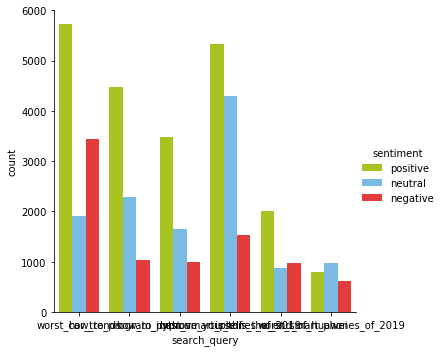

In [111]:
import seaborn as sns

sc = sns.factorplot(
    x="search_query",
    hue="sentiment",
    data=ycc,
    kind="count",
    palette={"negative": "#FE2020",
             "positive": "#BADD07",
             "neutral": "#68BFF5"}
)

In [4]:
ycc = preprocess_dataframe_text(ycc, 'text')
ycc.text.head()

0    people look back at my car mgb and laugh at ho...
1    for some ubsurd reson im having truble with in...
2    at m on file io o remove throw this error wind...
3    is there a way to just put this on a usb drive...
4    someone tell me that i am not the only one uns...
Name: text, dtype: object

In [5]:
from aruana import Aruana

aurana = Aruana('en')

Using TensorFlow backend.
/home/ego/anaconda3/envs/ai/lib/python3.6/site-packages/aruana/aruana.py:1258: Warning: Could not load model. Execution will continue, but you can't do annotations unless you download the necessary models.
  warnings.warn('Could not load model. Execution will continue, but you can\'t do annotations unless you download the necessary models.', Warning)


In [6]:
ycc['text'] = ycc['text'].apply(
    lambda x: aurana.preprocess(x, stem=False, tokenize=False, remove_stopwords=True)
)
ycc.text.head()

0    people look back car mgb laugh old fashioned r...
1    ubsurd reson im truble instaling module could ...
2    m file io o remove throw error windowserror er...
3                    way put usb drive upload computer
4    someone tell one unsubscribing resubscribing w...
Name: text, dtype: object

In [7]:
from spacy.lang.en import stop_words

def get_most_frequent_words(df, text_column, N_words=20):
    common_words = pd.Series(' '.join(
        df[text_column]).lower().split()).value_counts()[:N_words]
    uncommon_words = pd.Series(' '.join(
        df[text_column]).lower().split()).value_counts()[-N_words:]
    return common_words, uncommon_words

# we will add custom stop words to stop_words with union
common_words, uncommon_words = get_most_frequent_words(ycc, text_column='text')
df_stopwords = set(stop_words.STOP_WORDS)
df_stopwords = df_stopwords.union(list(common_words.keys()))
df_stopwords = df_stopwords.union(list(uncommon_words.keys()))

In [8]:
from vuepoint.vuepoint.models_pipeline import process_words

def sent_to_words(sentences):
    for sent in sentences:
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True)
        yield(sent)

data_list = ycc.text.values.tolist()
data_words = list(sent_to_words(data_list))
data_ready = process_words(data_words, stop_words=df_stopwords)

In [9]:
from vuepoint.vuepoint import NgramFreq

NgramFreq.get_top_unigrams(data_list, topn=20)

[('car', 8088),
 ('phone', 7306),
 ('video', 6736),
 ('like', 6539),
 ('one', 4697),
 ('wa', 3966),
 ('get', 3653),
 ('want', 3511),
 ('would', 3437),
 ('make', 3414),
 ('ha', 3017),
 ('python', 3010),
 ('huawei', 2970),
 ('time', 2928),
 ('best', 2800),
 ('good', 2784),
 ('sir', 2750),
 ('thing', 2635),
 ('new', 2625),
 ('know', 2594)]

In [10]:
NgramFreq.get_top_bigrams(data_list, topn=20)

[('rkiye rkiye', 692),
 ('mate pro', 635),
 ('going going', 519),
 ('thank much', 463),
 ('look like', 447),
 ('new car', 351),
 ('great video', 350),
 ('switch mate', 321),
 ('learn python', 320),
 ('pro switch', 319),
 ('redmi note', 318),
 ('make video', 290),
 ('note pro', 285),
 ('would like', 282),
 ('feel like', 277),
 ('year old', 273),
 ('best phone', 273),
 ('please help', 259),
 ('py line', 247),
 ('start stop', 246)]

In [11]:
NgramFreq.get_top_trigrams(data_list, topn=20)

[('rkiye rkiye rkiye', 691),
 ('going going going', 514),
 ('switch mate pro', 321),
 ('mate pro switch', 319),
 ('pro switch mate', 319),
 ('redmi note pro', 188),
 ('best driver car', 158),
 ('lib site package', 121),
 ('py line module', 111),
 ('self driving car', 106),
 ('low profile tire', 101),
 ('huawei mate pro', 98),
 ('happy new year', 96),
 ('traceback recent call', 94),
 ('recent call last', 93),
 ('tesla hater tesla', 92),
 ('hater tesla hater', 91),
 ('please make video', 90),
 ('give away give', 89),
 ('away give away', 89)]

**LDA model**
>- Gensim documentation link: [click here](https://radimrehurek.com/gensim/models/ldamodel.html)

In [12]:
id2word = corpora.Dictionary(data_ready)
corpus = [id2word.doc2bow(text) for text in data_ready]

In [13]:
# load model from disk
lda_model = gensim.models.ldamodel.LdaModel.load('ycc_dataset_large/ycc_lda_model/ycc_not_reply_lda.model')
pprint(lda_model.print_topics())

[(0,
  '0.031*"screen" + 0.025*"look" + 0.019*"bad" + 0.017*"sound" + '
  '0.016*"android" + 0.014*"think" + 0.013*"come" + 0.012*"agree" + '
  '0.011*"hit" + 0.011*"fake"'),
 (1,
  '0.046*"ban" + 0.034*"tech" + 0.026*"code" + 0.025*"run" + 0.022*"user" + '
  '0.022*"file" + 0.020*"error" + 0.020*"help" + 0.019*"write" + '
  '0.017*"charge"'),
 (2,
  '0.032*"life" + 0.023*"day" + 0.020*"people" + 0.015*"read" + 0.014*"mobile" '
  '+ 0.013*"think" + 0.012*"money" + 0.012*"game" + 0.012*"change" + '
  '0.011*"mind"'),
 (3,
  '0.047*"camera" + 0.016*"engine" + 0.015*"pixel" + 0.015*"manufacturer" + '
  '0.014*"power" + 0.013*"look" + 0.012*"grill" + 0.012*"suv" + 0.012*"turbo" '
  '+ 0.012*"design"'),
 (4,
  '0.029*"drive" + 0.016*"year" + 0.016*"old" + 0.015*"people" + 0.014*"look" '
  '+ 0.014*"vehicle" + 0.012*"stupid" + 0.012*"light" + 0.012*"hate" + '
  '0.011*"pro"'),
 (5,
  '0.034*"start" + 0.021*"stop" + 0.017*"turn" + 0.017*"work" + 0.015*"key" + '
  '0.014*"doe" + 0.014*"know" +

In [15]:
# load saved dominant topic dataframe
dominant_topic = pd.read_csv('ycc_dataset_large/ycc_not_reply_10topic_model.csv', index_col=0).reset_index()
dominant_topic.head()

,index,doc_num,dominant_topic,topic_perc_contrib,key_words,text
0,0,0,6.0,0.191849,"thank, great, learn, love, watch, course, tuto...","['people', 'look', 'mgb', 'laugh', 'old_fashio..."
1,1,1,1.0,0.702689,"ban, tech, code, run, user, file, error, help,...","['ubsurd', 'reson', 'truble', 'instaling', 'mo..."
2,2,2,1.0,0.391578,"ban, tech, code, run, user, file, error, help,...","['file', 'remove', 'throw', 'error', 'windowse..."
3,3,3,6.0,0.277531,"thank, great, learn, love, watch, course, tuto...","['way', 'usb', 'drive', 'upload', 'computer']"
4,4,4,9.0,0.700594,"company, china, battery, use, chinese, app, tr...","['tell', 'unsubscribe', 'resubscribe', 'win_xb..."


In [16]:
dominant_topic.key_words.unique()

array(['thank, great, learn, love, watch, course, tutorial, know, lot, country',
       'ban, tech, code, run, user, file, error, help, write, charge',
       'company, china, battery, use, chinese, app, trump, world, american, question',
       'life, day, people, read, mobile, think, money, game, change, mind',
       'screen, look, bad, sound, android, think, come, agree, hit, fake',
       'start, stop, turn, work, key, doe, know, system, find, computer',
       'drive, year, old, people, look, vehicle, stupid, light, hate, pro',
       'apple, samsung, print, iphone, smartphone, list, wait, review, main, device',
       'camera, engine, pixel, manufacturer, power, look, grill, suv, turbo, design',
       'buy, price, note, think, button, cheap, technology, sell, control, people'],
      dtype=object)

In [17]:
import pyLDAvis
import pyLDAvis.gensim

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word)
pyLDAvis.save_html(vis, 'ycc_not_reply_10topic_ldamodel.html')

/home/ego/anaconda3/envs/ai/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


>**pyLDAvis Visualizer** (click below to see the prepared LDA vidualization from above)

*To use the visualizer click* [here](ycc_dataset_large/ycc_not_reply_10topic_ldamodel.html)

In [19]:
from gensim.models import KeyedVectors

# load previously trained word2vec model - settings used are above
model = KeyedVectors.load_word2vec_format('ycc_dataset_large/word2vec_model/ycc_not_reply_w2v.bin', binary=False)

In [73]:
model.most_similar("pip_install", topn=20)

[('openpyxl', 0.637942910194397),
 ('pip', 0.6190963983535767),
 ('exe', 0.5896933078765869),
 ('keyerror', 0.5868715047836304),
 ('pypi', 0.5842578411102295),
 ('pywin_pyhook', 0.570973813533783),
 ('cmd', 0.5550776124000549),
 ('error', 0.5466264486312866),
 ('pyhook', 0.5411828756332397),
 ('directory', 0.5397024154663086),
 ('pycharm', 0.5250139236450195),
 ('sqlite', 0.5195713043212891),
 ('file', 0.5154427289962769),
 ('instal', 0.5126602649688721),
 ('script', 0.5071958899497986),
 ('interpreter', 0.5066741704940796),
 ('command_prompt', 0.5049246549606323),
 ('py', 0.4984384775161743),
 ('successfully', 0.4954785704612732),
 ('module_named', 0.4939050078392029)]

In [90]:
model.most_similar("nested_loop", topn=20)

[('tuple', 0.5732380747795105),
 ('col', 0.5249176025390625),
 ('converter', 0.49687251448631287),
 ('num_input_enter', 0.4912959933280945),
 ('loop', 0.48918554186820984),
 ('pied', 0.48072493076324463),
 ('multiplication', 0.47666797041893005),
 ('string', 0.4761608839035034),
 ('keyword', 0.4757091999053955),
 ('dictionary', 0.4721795618534088),
 ('ave', 0.4715415835380554),
 ('novice', 0.46954965591430664),
 ('unpack', 0.4578433632850647),
 ('emoji', 0.45750486850738525),
 ('boolean', 0.4574245810508728),
 ('swap_variable', 0.4556662440299988),
 ('inheritance', 0.4496500492095947),
 ('sublime_text', 0.44903281331062317),
 ('plus', 0.4448400139808655),
 ('press_enter', 0.4425002336502075)]

In [104]:
model.most_similar("voice_command", topn=20)

[('voice_control', 0.4823574423789978),
 ('gps', 0.45171433687210083),
 ('seat_belt', 0.45115789771080017),
 ('sex', 0.4472965598106384),
 ('touchscreen', 0.4457562565803528),
 ('stupidest', 0.43486639857292175),
 ('trek', 0.42281901836395264),
 ('gesture_control', 0.41785797476768494),
 ('touchpad', 0.4148028790950775),
 ('push_button', 0.4143819808959961),
 ('elderly', 0.41279441118240356),
 ('touch_screen', 0.4120672941207886),
 ('handbrake', 0.4082084000110626),
 ('tricky', 0.40386858582496643),
 ('knob', 0.4023815393447876),
 ('odyssey', 0.400799036026001),
 ('contradict', 0.39502018690109253),
 ('notify', 0.39446645975112915),
 ('range_rover', 0.3929946720600128),
 ('discourage', 0.3899795413017273)]

In [30]:
model.doesnt_match("facebook is the best app".split())

'app'

In [29]:
model.doesnt_match("is facebook is the worst app".split())

'worst'

In [33]:
smartphone_companies = ['apple', 'samsung', 'android', 'lg', 'sony', 'lenovo',
                        'microsoft', 'blackberry', 'motorola', 'xiaomi', 'huwei']

words = ['fast', 'safe', 'expensive', 'buying', 'deal_breaker',
         'modern', 'junk', 'cheap', 'stunning', 'ugly', 'design']

def brand_identity_association_by_word(words, brand_list):
    mosts_similar_associations =  model.most_similar_to_given
    for word in words:
        identity_match = mosts_similar_associations(
            entity1=word, entities_list=brand_list
        )
        print(f"{word.upper()}: is associated to: {identity_match.upper()}")

In [34]:
brand_identity_association_by_word(words, smartphone_companies)

FAST: is associated to: SAMSUNG
SAFE: is associated to: LG
EXPENSIVE: is associated to: SAMSUNG
BUYING: is associated to: HUWEI
DEAL_BREAKER: is associated to: ANDROID
MODERN: is associated to: APPLE
JUNK: is associated to: HUWEI
CHEAP: is associated to: SAMSUNG
STUNNING: is associated to: LG
UGLY: is associated to: APPLE
DESIGN: is associated to: ANDROID
